# Project Summary: London Maximum Temperature Forecasting

## Objective
* Built a time series model to predict future maximum temperatures in London based on historical data.

## Critical Variable Selection (TX vs. TG)
* **Forecasting Maximum (TX) over Mean (TG):** Mean temperatures artificially smooth the data and mask extreme events.
* **Real-World Impact:** Forecasting `TX` is more challenging due to higher variance, but it provides actionable insights for real-world impacts like infrastructure strain and heat stress.
* **Climate Signal:** Tracking maximums better captures the aggressive warming trends of climate change at the extremes.

## Data Preparation & Splitting
* **Indexing:** Set the `DATE` column as the index.
* **Resampling:** Aggregated the daily data into monthly maximums to establish a clear 12-month seasonal cycle.
* **Train/Test Split:** Divided the 44-year dataset into a training set (1979–2018) to train the model, and a hidden testing set (2019–2023) to evaluate real-world accuracy.

## Modeling Approach
* **Algorithm:** Implemented a Holt-Winters Triple Exponential Smoothing model using `statsmodels`.
* **Configuration:** Configured the model with an additive trend and an additive 12-month seasonal period to map London's annual weather rhythm.

## Performance Results
* **Mean Absolute Error (MAE): 2.28°C.** On average, predictions were off by about 2.3 degrees from actual extreme highs.
* **Mean Squared Error (MSE): 9.18.** * **Root Mean Squared Error (RMSE): 3.03°C.** Because RMSE penalizes large errors heavily, the gap between MAE and RMSE indicates the model missed a few massive, unexpected heat spikes (likely recent record-breaking UK heatwaves).

In [ ]:
#1. Import Required Libraries
import sys
!{sys.executable} -m pip install --upgrade statsmodels
!{sys.executable} -m pip install --upgrade scikit-learn


In [22]:
import pandas as pd
import os
import kagglehub
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import sklearn
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [ ]:
dataset_handle = "zongaobian/london-weather-data-from-1979-to-2023"
path = kagglehub.dataset_download(dataset_handle)

In [24]:
files = os.listdir(path)
print(files)

['london_weather_data_1979_to_2023.csv']


In [25]:
# Create the full path to the specific file
csv_path = os.path.join(path, "london_weather_data_1979_to_2023.csv")

# Load the data
df = pd.read_csv(csv_path)

2. Load and Prepare the Time Series Data
Time series models require the date to be the "index" of the dataframe, not just a regular column.

The reasons to choose Maximum temperature (TX) over Mean temperature (TG)
- Climate Change Sensitivity: Historical warming trends often manifest most aggressively in the upper extremes (higher daily highs) rather than a uniform shift in the daily average. TX isolates this specific warming signal.
- The Modeling Trade-off: Critically, the Holt-Winters model will actually produce a "cleaner," mathematically tighter forecast on TG because the data has lower variance. Choosing TX intentionally forces the model to handle a noisier, more volatile dataset to see if it can capture the peaks.

In [26]:
# Format date and scale the Maximum Temperature (TX)
df['DATE'] = pd.to_datetime(df['DATE'], format='%Y%m%d')
df['TX'] = df['TX'] / 10.0

# Set DATE as the index 
df.set_index('DATE', inplace=True)

# Resample to Monthly Maximums ('ME' = Month End)
# This finds the absolute hottest day of each month, simplifying the 365-day cycle to a 12-month cycle
ts_tx = df['TX'].resample('ME').max()

3. Split into Training and Testing Sets
We will train the model on data from 1979 to 2018, and hide the 2019–2023 data so we can test the model's accuracy against real, unseen weather.

In [27]:
# Split the data
train_data = ts_tx[:'2018']
test_data = ts_tx['2019':]

print(f"Training months: {len(train_data)}")
print(f"Testing months: {len(test_data)}")

Training months: 480
Testing months: 60


4. Build and Fit the Holt-Winters Model
We configure the model to expect an additive trend (temperatures slowly rising) and an additive seasonal cycle repeating every 12 months.

In [28]:
# Initialize the Triple Exponential Smoothing model
hw_model = ExponentialSmoothing(
    train_data, 
    trend='add', 
    seasonal='add', 
    seasonal_periods=12 # 12 months in a yearly cycle
)

# Fit the model to the training data
fitted_model = hw_model.fit()

5. Generate the Forecast and Plot
We ask the model to predict the same number of months that exist in our hidden test set, then plot them together to visually evaluate the accuracy.

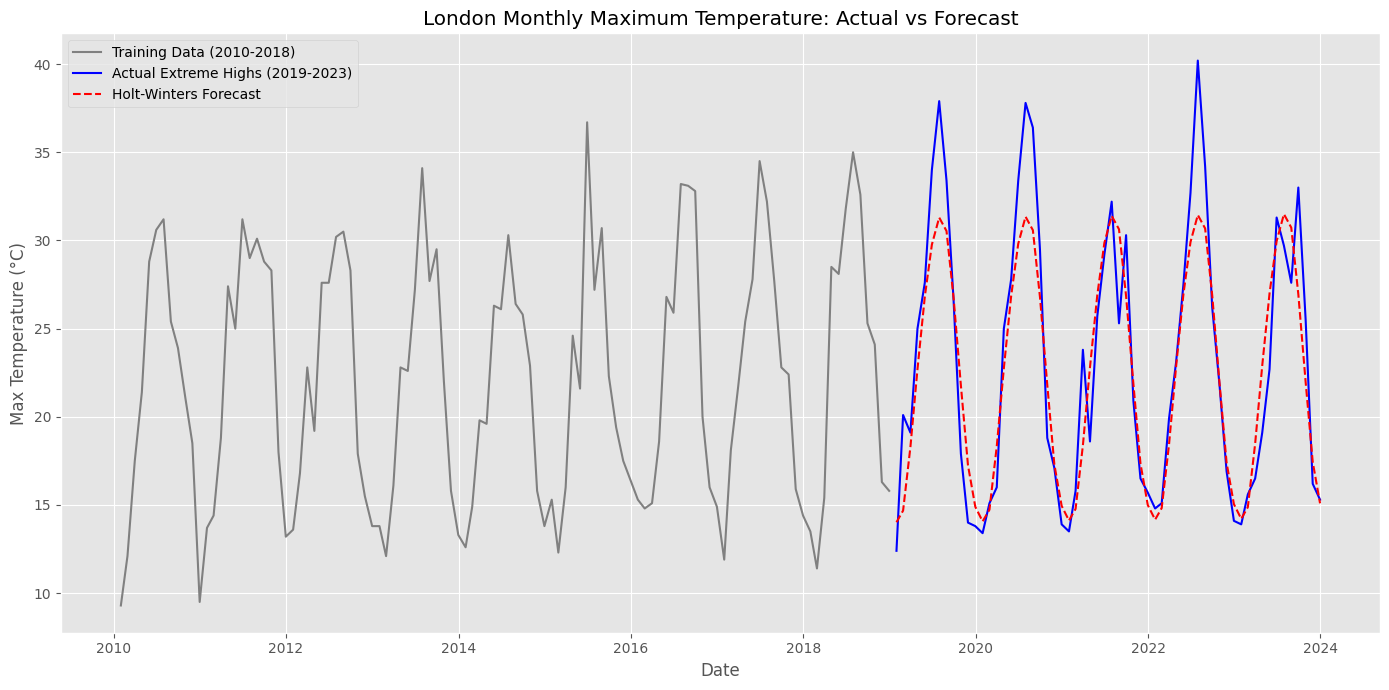

In [29]:
# Forecast future values
forecast_steps = len(test_data)
predictions = fitted_model.forecast(forecast_steps)

# Set plot style for better readability
plt.style.use('ggplot')

# Plot the Actual vs Predicted values
plt.figure(figsize=(14, 7))

# Plot the last few years of training data for context
plt.plot(train_data['2010':], label='Training Data (2010-2018)', color='gray')

# Plot the actual test data
plt.plot(test_data, label='Actual Extreme Highs (2019-2023)', color='blue')

# Plot the model's forecast
plt.plot(predictions, label='Holt-Winters Forecast', color='red', linestyle='--')

plt.title('London Monthly Maximum Temperature: Actual vs Forecast')
plt.xlabel('Date')
plt.ylabel('Max Temperature (°C)')
plt.legend()
plt.tight_layout()
plt.savefig('tx_temperature_forecast.png')

To understand how far off our predictions were from the actual 2019-2023 temperatures, we will use three common evaluation metrics.
- Mean Absolute Error (MAE)
- Mean Squared Error (MSE)
- Root Mean Squared Error (RMSE)

In [30]:

# 1. Calculate the Mean Absolute Error (MAE)
mae = mean_absolute_error(test_data, predictions)

# 2. Calculate the Mean Squared Error (MSE)
mse = mean_squared_error(test_data, predictions)

# 3. Calculate the Root Mean Squared Error (RMSE)
rmse = np.sqrt(mse)

# 4. Print the final evaluation metrics
print("--- Forecast Evaluation Metrics ---")
print(f"Mean Absolute Error (MAE): {mae:.2f}°C")
print(f"Mean Squared Error (MSE): {mse:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}°C")

--- Forecast Evaluation Metrics ---
Mean Absolute Error (MAE): 2.28°C
Mean Squared Error (MSE): 9.18
Root Mean Squared Error (RMSE): 3.03°C
